# Fido, HelioCloud, SDOML

In [ ]:
import matplotlib.pyplot as plt

def plot_smap(smap):
    fig = plt.figure()
    ax = fig.add_subplot(projection=smap)
    smap.plot(axes=ax)
    plt.show()

## Fido

In [ ]:
import astropy.units as u
from sunpy.net import Fido, attrs as a
from sunpy.map import Map

tr = a.Time("2010-05-13T00:00:00", "2010-05-13T00:00:12")
aia_query = Fido.search(tr & a.Instrument.aia & a.Wavelength(94*u.angstrom))
print(aia_query)
filelist_fido = Fido.fetch(aia_query, path="data/{instrument}")

Results from 1 Provider:

1 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Total estimated size: 67.789 Mbyte

       Start Time               End Time        Source Instrument  Wavelength  Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                    Angstrom                                                                       Mibyte 
----------------------- ----------------------- ------ ---------- ------------ -------- --------- -------- ------------ ------------- ----------- --------
2010-05-13 00:00:02.000 2010-05-13 00:00:03.000    SDO        AIA 94.0 .. 94.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [ ]:
len(filelist_fido)

1

data\AIA\aia.lev1.94A_2010_05_13T00_00_02.12Z.image_lev1.fits


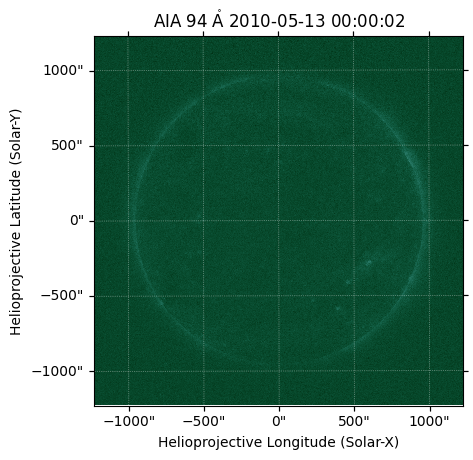

In [ ]:
print(filelist_fido[0])
smap_fido = Map(filelist_fido[0])
plot_smap(smap_fido)

## HelioCloud

In [ ]:
import cloudcatalog

def id_to_filelist(bucket_name, frID):
    fr = cloudcatalog.CloudCatalog(bucket_name)
    myjson = fr.get_entry(frID)
    file_registry = fr.request_cloud_catalog(frID, 
        start_date=myjson['start'], 
        stop_date=myjson['stop'], 
        overwrite=False
    )
    filelist = file_registry['datakey'].to_list()
    return filelist

filelist_hc = id_to_filelist("s3://gov-nasa-hdrl-data1/", "aia_0094")

In [ ]:
len(filelist_hc)

1496151

s3://gov-nasa-hdrl-data1/sdo/aia/20100513/0094/sdo_aia_h2_20100513T000000_0094_v1.fits


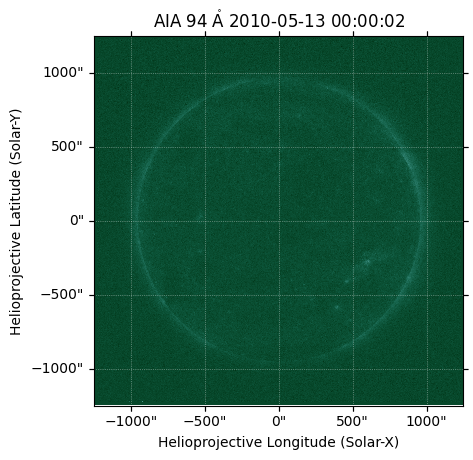

In [ ]:
import s3fs
from astropy.io import fits

def s3_to_map(file):
    fs = s3fs.S3FileSystem(anon=True)
    fgrab = fs.open(file)
    hdul = fits.open(fgrab)
    smap = Map(hdul[1].data, hdul[1].header)
    return smap

print(filelist_hc[0])
smap_hc = s3_to_map(filelist_hc[0])
plot_smap(smap_hc)

## SDOML

In [ ]:
import os
import s3fs
import zarr

from typing import Union

import numpy as np
import dask.array as da

def s3_connection(path_to_zarr: os.path) -> s3fs.S3Map:
    """
    Instantiate connection to aws for a given path `path_to_zarr`
    """
    return s3fs.S3Map(
        root=path_to_zarr,
        s3=s3fs.S3FileSystem(anon=True),
        # anonymous access requires no credentials
        check=False,
    )


def load_single_aws_zarr(
    path_to_zarr: os.path,
    cache_max_single_size: int = None,
) -> Union[zarr.Array, zarr.Group]:
    """
    load zarr from s3 using LRU cache
    """
    return zarr.open(
        zarr.LRUStoreCache(
            store=s3_connection(path_to_zarr),
            max_size=cache_max_single_size,
        ),
        mode="r",
    )

root = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2.zarr/",
)
data = root["2010"]["94A"]
print(data)
sorted_indices = np.argsort(data.attrs["T_OBS"])
img_index = sorted_indices[0]
selected_headr = {keys: values[img_index] for keys, values in data.attrs.items()}
selected_image = da.from_array(data)[img_index, :, :]
selected_image

<zarr.core.Array '/2010/94A' (46930, 512, 512) float32 read-only>


dask.array<getitem, shape=(512, 512), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>

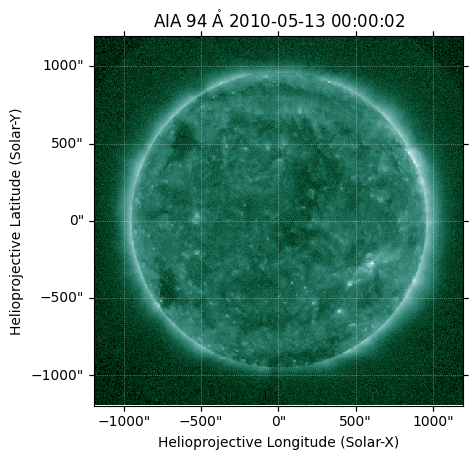

In [ ]:
smap_ml = Map((np.array(selected_image), selected_headr))
plot_smap(smap_ml)

## Comparison

In [ ]:
print("Fido:         ", smap_fido.meta["T_OBS"])
print("HelioCloud:   ", smap_hc.meta["T_OBS"])
print("SDOML:        ", smap_ml.meta["T_OBS"])

Fido:          2010-05-13T00:00:03.57Z
HelioCloud:    2010-05-13T00:00:03.572
SDOML:         2010-05-13T00:00:03.57Z


In [ ]:
print("Fido:         ", smap_fido.data.shape)
print("HelioCloud:   ", smap_hc.data.shape)
print("SDOML:        ", smap_ml.data.shape)

Fido:          (4096, 4096)
HelioCloud:    (5000, 5000)
SDOML:         (512, 512)


In [ ]:
print("Fido:         ", smap_fido.data.mean())
print("HelioCloud:   ", smap_hc.data.mean())
print("SDOML:        ", smap_ml.data.mean())

Fido:          1.2187774
HelioCloud:    1.1448832
SDOML:         0.458365


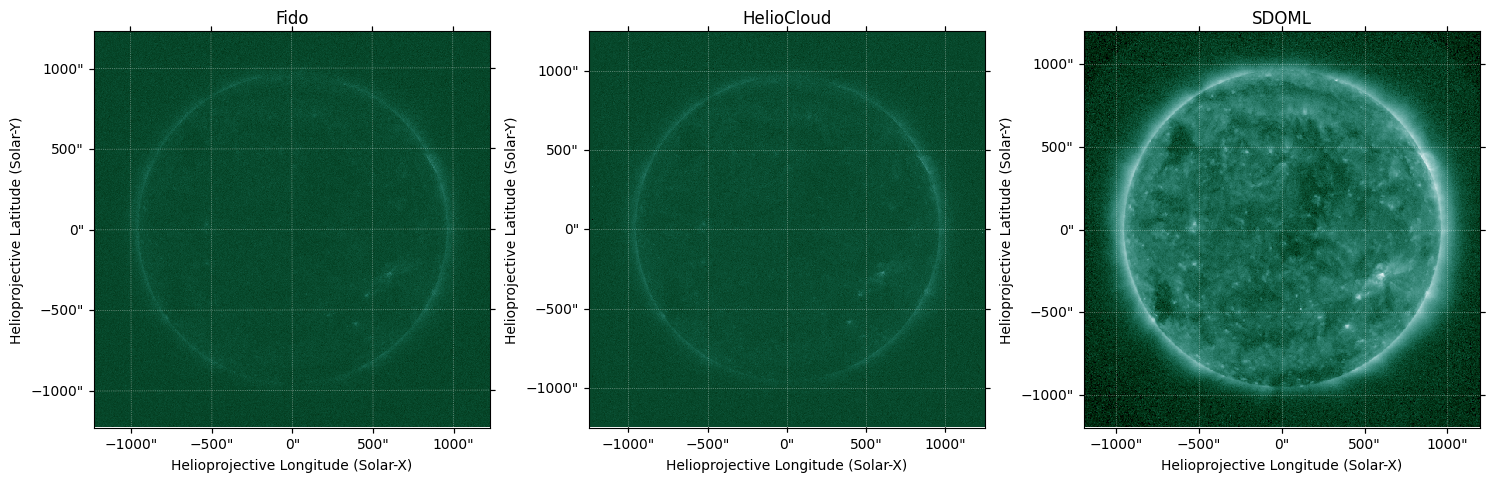

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131, projection=smap_fido)
smap_fido.plot(axes=ax1)
ax1.set_title("Fido")

ax2 = fig.add_subplot(132, projection=smap_hc)
smap_hc.plot(axes=ax2)
ax2.set_title("HelioCloud")

ax3 = fig.add_subplot(133, projection=smap_ml)
smap_ml.plot(axes=ax3)
ax3.set_title("SDOML")

fig.tight_layout()
plt.show()

In [ ]:
keys_fido = smap_fido.meta.keys()
keys_hc = smap_hc.meta.keys()
keys_ml = smap_ml.meta.keys()

for key in keys_fido:
    print(f"Fido:         {key} = {smap_fido.meta[key]}")

    if key not in keys_hc:
        print(f"Key {key} is not in HelioCloud")
    else:
        print(f"HelioCloud:   {key} = {smap_hc.meta[key]}")
    
    if key not in keys_ml:
        print(f"Key {key} is not in SDOML")
    else:
        print(f"SDOML:        {key} = {smap_ml.meta[key]}")

    print()

Fido:         xtension = IMAGE
Key xtension is not in HelioCloud
SDOML:        xtension = IMAGE

Fido:         bitpix = 16
HelioCloud:   bitpix = 32
SDOML:        bitpix = 32

Fido:         naxis = 2
HelioCloud:   naxis = 2
SDOML:        naxis = 2

Fido:         naxis1 = 4096
HelioCloud:   naxis1 = 5000
SDOML:        naxis1 = 512.0

Fido:         naxis2 = 4096
HelioCloud:   naxis2 = 5000
SDOML:        naxis2 = 512.0

Fido:         pcount = 0
Key pcount is not in HelioCloud
SDOML:        pcount = 0

Fido:         gcount = 1
Key gcount is not in HelioCloud
SDOML:        gcount = 1

Fido:         bld_vers = V5R12X
Key bld_vers is not in HelioCloud
Key bld_vers is not in SDOML

Fido:         lvl_num = 1.0
HelioCloud:   lvl_num = 2.0
SDOML:        lvl_num = 1.5

Fido:         t_rec = 2010-05-13T00:00:04Z
HelioCloud:   t_rec = 2010.05.13_00:00:26.000_UTC
SDOML:        t_rec = 2010-05-13T00:00:04Z

Fido:         trecstep = 1.0
HelioCloud:   trecstep = 60.0
SDOML:        trecstep = 180.0

Fido